In [1]:
# importing packages for future use

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statistics
import math
import scipy.integrate as integrate
import warnings
warnings.simplefilter('ignore')
from scipy import stats as sci

In [2]:
# defining functions for future use

# this function implements the log-normal probability density function with parameters mu and sigma. An amplitude parameter is included later on
def log_normal_pdf(x, mu, sigma):
    return (np.exp(-((x - mu)**2 / (2 * sigma**2)))) / (sigma * np.sqrt(2 * np.pi))

# this function takes in a list and returns the index of the list that is closest to any given number (used in pdf "error bars")
def closest(list, number):
    x = []
    for value in list:
        x.append(abs(number-value))
    return x.index(min(x))


In [3]:
# Survey Simulation

# assumed fit parameters (similar to those in Dr. Winters' Thesis)
assumed_log_mu = 1.3
assumed_log_sigma = 1.1
assumed_A = .5

# integrating over the log-normal pdf with assumed fit parameters to compute a frequency
int_1 = integrate.quad(lambda x: log_normal_pdf(x, assumed_log_mu, assumed_log_sigma) , np.log10(1), np.log10(10))
int_2 = integrate.quad(lambda x: log_normal_pdf(x, assumed_log_mu, assumed_log_sigma) , np.log10(10), np.log10(100))
int_3 = integrate.quad(lambda x: log_normal_pdf(x, assumed_log_mu, assumed_log_sigma) , np.log10(100), np.log10(1000))
int_4 = integrate.quad(lambda x: log_normal_pdf(x, assumed_log_mu, assumed_log_sigma) , np.log10(1000), np.log10(10000))

# amplitude is pulled out of the integral and accounted for here
test_freq_1 = assumed_A * int_1[0]
test_freq_2 = assumed_A * int_2[0]
test_freq_3 = assumed_A * int_3[0]
test_freq_4 = assumed_A * int_4[0]

# parent popultion of simulated survey - represents the total number of stars surveyed
test_parent = 10**2

# companion population of simulated survey - this represent the number of companion detections 
companions_1 = int(test_freq_1 * test_parent)
companions_2 = int(test_freq_2 * test_parent)
companions_3 = int(test_freq_3 * test_parent)
companions_4 = int(test_freq_4 * test_parent)

# poisson error in context of frequency (for use in reduced chi-squared test)
test_f_error_1 = math.sqrt(companions_1) / test_parent
test_f_error_2 = math.sqrt(companions_2) / test_parent
test_f_error_3 = math.sqrt(companions_3) / test_parent
test_f_error_4 = math.sqrt(companions_4) / test_parent

# simulted survey frequencies (adds noise to frequencies drawn from assumed fit parameters)
# frequency values randomly generated from a poisson distribution with a mean of the number of companions found above
# these frequencies represent data points from surveys 
random_freq_1 = np.random.poisson(companions_1) / test_parent
random_freq_2 = np.random.poisson(companions_2) / test_parent
random_freq_3 = np.random.poisson(companions_3) / test_parent
random_freq_4 = np.random.poisson(companions_4) / test_parent

# range of potential parameter values - the fit will test each and every single one of these against one-another
mu_range = np.arange(-2, 5, .1)
sigma_range = np.arange(-2, 4, .1)
A_range = np.arange(.1, 2, .1)

# a blank cube which will later be filled with reduced chi-squared values
cube = np.zeros([len(A_range),len(sigma_range),len(mu_range)]) # layers, rows, columns

# initializing constants for use in the fit process
x, y, z = 0, 0, 0
chi_list = []
min_chi = 100
best_mu = "none"
best_sigma = "none"
best_A = "none"

# the fit process
# calculates model frequencies using every single possible parameter value and compares the model frequencies to the simulated survey frequencies using the reduced chi-squared test
for i in range(len(A_range)):
    for j in range(len(sigma_range)):
        for k in range(len(mu_range)):
            
            # storing parameter values
            log_mu = mu_range[k]
            log_sigma = mu_range[j]
            A = A_range[i]
            
            # creating model frequency (uses same log-normal pdf as above)
            int_1 = integrate.quad(lambda x: log_normal_pdf(x, mu_range[k], sigma_range[j]) , np.log10(1), np.log10(10))
            int_2 = integrate.quad(lambda x: log_normal_pdf(x, mu_range[k], sigma_range[j]) , np.log10(10), np.log10(100))
            int_3 = integrate.quad(lambda x: log_normal_pdf(x, mu_range[k], sigma_range[j]) , np.log10(100), np.log10(1000))
            int_4 = integrate.quad(lambda x: log_normal_pdf(x, mu_range[k], sigma_range[j]) , np.log10(1000), np.log10(10000))

            # accounting for amplitude
            model_1 = A_range[i] * int_1[0]
            model_2 = A_range[i] * int_2[0]
            model_3 = A_range[i] * int_3[0]
            model_4 = A_range[i] * int_4[0]

            # calculating individual reduced chi-sqaured values 
            x_1 = np.power(model_1 - random_freq_1, 2) / np.power(test_f_error_1, 2)
            x_2 = np.power(model_2 - random_freq_2, 2) / np.power(test_f_error_2, 2)
            x_3 = np.power(model_3 - random_freq_3, 2) / np.power(test_f_error_3, 2)
            x_4 = np.power(model_4 - random_freq_4, 2) / np.power(test_f_error_4, 2)

            # summing individual reduced chi-squared values up, dividing by nu
            x_list = [x_1,x_2,x_3,x_4]
            nu = len(x_list) - 3 # data points - fitted parameters            
            chi_sq = (1 / nu) * sum(x_list)
            
            # reduced chi-squared values are stored in a cube - the exact fit parameters used to calculate it are retained as the index of the cube
            cube[i][j][k] = chi_sq
            
            # checking for the best fit parameter values
            # the parameter values used in calculating a reduced chi-squared value that is closest to 1 are considered to be the best fit
            chi_dev = abs(1 - chi_sq)
            # incrementally checks every chi-squared value to find best fit
            if chi_dev < min_chi:
                min_chi = chi_dev
                best_mu = log_mu
                best_sigma = log_sigma
                best_A = A
                best_chi = chi_sq

# printing out best fit values and associated reduced chi-squared
print("Best chi-sq, log(mu), log(sigma), A =", best_chi, best_mu, best_sigma, best_A) 

# print(cube)

Best chi-sq, log(mu), log(sigma), A = 0.9718536919433272 1.300000000000003 1.1000000000000028 0.4


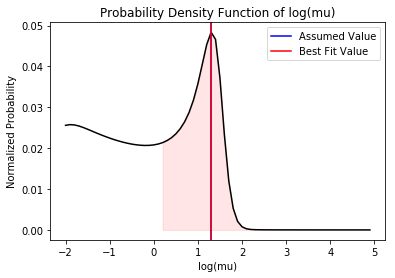

Assumed log(mu) = 1.3
Best Fit log(mu) = 1.300000000000003 ( 0.20000000000000195  -  4.900000000000006 )


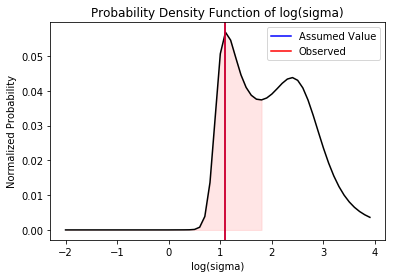

Assumed sigma = 1.1
Observed sigma = 1.1000000000000028 ( -2.0  -  1.8000000000000034 )


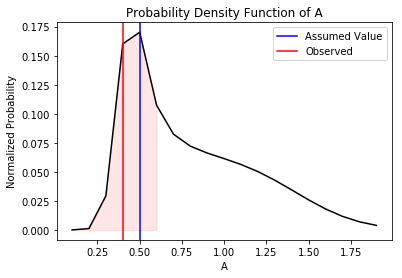

Assumed A = 0.5
Observed A = 0.4 ( 0.1  -  0.6 )


In [4]:
# initializing proability cube
prob_cube = np.zeros([len(A_range),len(sigma_range),len(mu_range)]) # layers, rows, columns

# chi-squared probability formula
def prob_chi(x):
    return x ** ((nu-2)/2) * np.exp(-x/2)

# converting cube from reduced chi-squared values to probabilities (from chi-squared distribution)
for i in range(len(A_range)): # layers
    for j in range(len(sigma_range)): # columns
        for k in range(len(mu_range)): # rows
                prob_cube[i][j][k] = prob_chi(cube[i][j][k])

                
# The following code computes the 1-D pdf's of each of the three fit parameters. First, log(mu). Then, log(sigma) and finally A
      
    
# mu 1-D pdf

# collapsing cube to one dimension
sigmaxmu = np.sum(prob_cube, 0)
mu = np.sum(sigmaxmu, 0)

# normalizing pdf by summing values and multiplying by the amplitude that makes this sum equal to 1
area = sum(mu)
norm_const_mu = 1 / area
norm_mu = norm_const_mu * mu

# drawing "error bars" on the pdf: 
# a cumulative integration gives successive areas under the curve
area_under_1 = integrate.cumtrapz(norm_mu, initial=0)
range_index_1 = closest(mu_range, best_mu)
# 33% of the data on either side of the best fit value is highlighted
width_1 = .66
lower_1 = area_under_1[range_index_1] - (width_1 / 2)
upper_1 = area_under_1[range_index_1] + (width_1 / 2)
lower_index_1 = closest(area_under_1, lower_1)
upper_index_1 = closest(area_under_1, upper_1)

# Graphing
plt.plot(mu_range, norm_mu, color="black")
plt.title("Probability Density Function of log(mu)")
plt.xlabel("log(mu)")
plt.ylabel("Normalized Probability")
plt.axvline(x=assumed_log_mu, color="blue", label="Assumed Value")
plt.axvline(x=best_mu, color="red", label = "Best Fit Value")
plt.legend()
plt.savefig("log(mu)_pdf")
# The following line highlights 66% of the data centered on the best fit value (found above)
plt.fill_between(mu_range[lower_index_1:upper_index_1+1], norm_mu[lower_index_1:upper_index_1+1], color="red", alpha=.1)
plt.show()

print("Assumed log(mu) =", assumed_log_mu)
print("Best Fit log(mu) =", best_mu, "(", mu_range[lower_index_1], " - ", mu_range[upper_index_1], ")")



# sigma 1-D pdf

# collapsing cube to one dimension
sigmaxmu = np.sum(prob_cube, 0)
sigma = np.sum(sigmaxmu, 1)

# normalizing pdf by summing values and multiplying by the amplitude that makes this sum equal to 1
area = sum(sigma)
norm_const_sigma = 1 / area
norm_sigma = norm_const_sigma * sigma

# drawing "error bars" on the pdf: 
# a cumulative integration gives successive areas under the curve
area_under_2 = integrate.cumtrapz(norm_sigma, initial=0)
range_index_2 = closest(sigma_range, best_sigma)
# 33% of the data on either side of the best fit value is highlighted
width_2 = .66
lower_2 = area_under_2[range_index_2] - (width_2 / 2)
upper_2 = area_under_2[range_index_2] + (width_2 / 2)
lower_index_2 = closest(area_under_2, lower_2)
upper_index_2 = closest(area_under_2, upper_2)

# Graphing
plt.plot(sigma_range, norm_sigma, color="black")
plt.title("Probability Density Function of log(sigma)")
plt.xlabel("log(sigma)")
plt.ylabel("Normalized Probability")
plt.axvline(x=assumed_log_sigma, color="blue", label="Assumed Value")
plt.axvline(x=best_sigma, color="red", label = "Observed")
plt.legend()
plt.savefig("log(sigma)_pdf")
# The following line highlights 66% of the data centered on the best fit value (found above)
plt.fill_between(sigma_range[lower_index_2:upper_index_2+1], norm_sigma[lower_index_2:upper_index_2+1], color="red", alpha=.1)
plt.show()

print("Assumed sigma =", assumed_log_sigma)
print("Observed sigma =", best_sigma, "(", sigma_range[lower_index_2], " - ", sigma_range[upper_index_2], ")")



# A 1-D pdf

# collapsing cube to one dimension
Axsigma = np.sum(prob_cube, 2)
A = np.sum(Axsigma, 1)

# normalizing pdf by summing values and multiplying by the amplitude that makes this sum equal to 1
area = sum(A)
norm_const_A = 1 / area
norm_A = norm_const_A * A

# drawing "error bars" on the pdf: 
# a cumulative integration gives successive areas under the curve
area_under_3 = integrate.cumtrapz(norm_A, initial=0)
range_index_3 = closest(A_range, best_A)
# 33% of the data on either side of the best fit value is highlighted
width_3 = .66
lower_3 = area_under_3[range_index_3] - (width_3 / 2)
upper_3 = area_under_3[range_index_3] + (width_3 / 2)
lower_index_3 = closest(area_under_3, lower_3)
upper_index_3 = closest(area_under_3, upper_3)

# Graphing
plt.plot(A_range, norm_A, color="black")
plt.title("Probability Density Function of A")
plt.xlabel("A")
plt.ylabel("Normalized Probability")
plt.axvline(x= assumed_A, color="blue", label="Assumed Value")
plt.axvline(x=best_A, color="red", label = "Observed")
# The following line highlights 66% of the data centered on the best fit value (found above)
plt.fill_between(A_range[lower_index_3:upper_index_3+1], norm_A[lower_index_3:upper_index_3+1], color="red", alpha=.1)
plt.legend()
plt.savefig("A_pdf")
plt.show()

print("Assumed A =", assumed_A)
print("Observed A =", best_A, "(", A_range[lower_index_3], " - ", A_range[upper_index_3], ")")


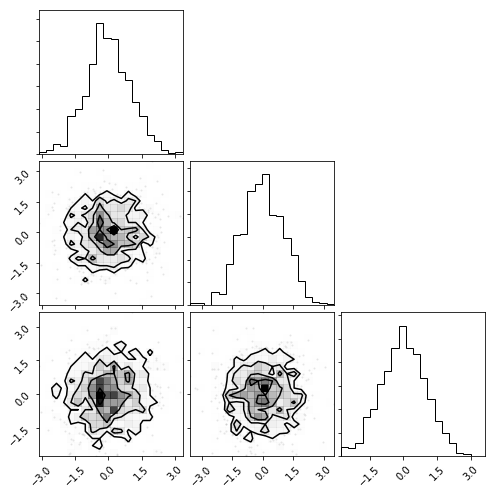

In [5]:
# attempting to implement a corner plot
import corner

# the following is randomly generated data for testing purposes (represents the three fit parameters)
data1 = np.random.randn(1000)
data2 = np.random.randn(1000)
data3 = np.random.randn(1000)
data = np.stack((data1, data2, data3), 1)

figure = corner.corner(data)